# Imports

In [1]:
import numpy as np
import networkx as nx
import plotly.graph_objects as go
import gudhi as gd
import matplotlib.pyplot as plt

# Functions

In [2]:
# Inputs: ts - a 2D np array of any shape. Probably a time series. 
# b - the number of bins in each dimension
# Output: bins - A dictionary of arrays that contains the boundaries of the bins in each dimension

def get_bins(ts,b):
    d,n = ts.shape
    bins = {}
    for i in range(d):
        top = max(ts[i,:])
        bot = min(ts[i,:])
        step = (top - bot)/b
        ibins = []
        for j in range(b+1):
            ibins.append(bot+j*step)
        bins[i] = ibins
    return bins

In [3]:
# Inputs: ts - time series
# bins - the partition of each dimension into its bins
# b - number of bins in each dimension

# Output: binseq - a 1D array the length of ts that lists which bin each entry in the time series is in

def bin_sequence(ts, bins, b):
    d,n = ts.shape
    binseq = np.zeros((n))
    for i in range(n):
        bin_n = 0
        for j in range(d):
            k = 1
            while k <= b:
                if ts[j,i] <= bins[j][k]:
                    bin_n += (k-1)*(b**j)
                    k = b + 1
                else: 
                    k = k + 1 
        binseq[i] = bin_n

    return binseq

In [4]:
# inputs: bin-seq - the bin sequence of the time series
# outputs: A - the adjacency matrix
# vertices - the list of vertices, enumerated as bin number

def adjacency(bin_seq, prob = False):
    vertices, counts = np.unique(bin_seq, return_counts=True)
    order = len(vertices)
    A = np.zeros((order,order))
    for i in range(len(bin_seq)-1):
        A[np.where(vertices == bin_seq[i]),np.where(vertices == bin_seq[i+1])] += 1
    if prob:
        A[:,i] = A[:,i]/np.sum(A[:,i])
    return A, vertices, counts

In [5]:
# inputs: A - the adjacency matrix
# vertices - the list of vertices, which are the bin numbers
# loops - whether or not to keep the self-loops in the graph, I am going to do something with this eventually when I include some sort of markovian random walk diffusion distance 
# Output: G - a networkx digraph

def digraph(A, vertices, counts, loops: bool):
    if loops == False:
        np.fill_diagonal(A,0)
        G = nx.DiGraph(A)
    elif loops == True:
        G = nx.DiGraph(A)
    for i in range(len(G.nodes)):
       G.nodes[i]['bin'] = vertices[i]
       G.nodes[i]['count'] = counts[i]

    return G

In [6]:
def bin_centers(bins, b):
    bin_cent = np.zeros((b**3,3))
    for k in range(b):
        for j in range(b):
            for i in range(b):
                bin_cent[k*b**2 + j*b + i,0] += np.mean(bins[0][i:i+2]) 
                bin_cent[k*b**2 + j*b + i,1] += np.mean(bins[1][j:j+2]) 
                bin_cent[k*b**2 + j*b + i,2] += np.mean(bins[2][k:k+2]) 

    return bin_cent

In [7]:
def graph_graph(G: nx.DiGraph, bin_cents: np.ndarray, perc: float = 0, arrows: bool = False, color_verts: bool = False):
    """
    Plot nodes at bin_cents positions. G.nodes[i]['bin'] is an integer indexing into bin_cents.
    Assumes bin_cents shape (b**d, d). For plotting we require d >= 3; if d>3 we use first 3 coords.
    perc: percentile cutoff for highlighting dense vertices (only used if color_verts True)
    """
    d = bin_cents.shape[1]
    if d < 3:
        raise ValueError("Need at least 3 coordinates for 3D plotting")
    # collect node positions
    xs, ys, zs = [], [], []
    for node in G.nodes:
        bidx = int(G.nodes[node]['bin'])
        xs.append(float(bin_cents[bidx, 0]))
        ys.append(float(bin_cents[bidx, 1]))
        zs.append(float(bin_cents[bidx, 2]))

    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=xs, y=ys, z=zs, mode='markers',
                               marker=dict(size=3, color='black', line=dict(width=1, color='white')),
                               showlegend=False))
    # edges (lines) and optional cones for arrows
    if arrows:
        for u, v, data in G.edges(data=True):
            start = bin_cents[int(G.nodes[u]['bin'])]
            end = bin_cents[int(G.nodes[v]['bin'])]
            fig.add_trace(go.Scatter3d(x=[start[0], end[0]], y=[start[1], end[1]], z=[start[2], end[2]],
                                       mode='lines', line=dict(width=1), showlegend=False))
            # cone (arrow head)
            dx, dy, dz = (end - start)
            # plot cone at end only if vector nonzero
            if np.linalg.norm([dx, dy, dz]) > 1e-12:
                fig.add_trace(go.Cone(x=[end[0]], y=[end[1]], z=[end[2]],
                                      u=[dx], v=[dy], w=[dz],
                                      sizemode='absolute', sizeref=0.3, showscale=False,
                                      anchor='tip', colorscale=[[0,'black'],[1,'black']], showlegend=False))
    # colored vertices
    if color_verts:
        counts = np.array([G.nodes[n]['count'] for n in G.nodes])
        thr = np.percentile(counts, 100 - perc) if perc > 0 else np.min(counts)-1  # if perc==0 don't highlight any
        mask = counts >= thr
        if mask.any():
            node_x = np.array(xs)[mask]
            node_y = np.array(ys)[mask]
            node_z = np.array(zs)[mask]
            fig.add_trace(go.Scatter3d(x=node_x, y=node_y, z=node_z, mode='markers',
                                       marker=dict(size=4, color=counts[mask], colorbar=dict(title="Counts")),
                                       showlegend=False))
    fig.update_layout(scene=dict(aspectmode='cube'))
    return fig

In [8]:
#Inputs: G - a networkx graph
# method - the way you want to measure distance on the graph
# Outputs: D - a distance matrix

def distance_matrix(G, method = 'unweighted_shortest_path'):
    if method == 'unweighted_shortest_path':
        lengths = dict(nx.all_pairs_shortest_path_length(G))
        D = np.full((len(lengths),len(lengths)),1000,dtype=float) # was -1 default
        for key in lengths:
            for item in lengths[key]:
                    D[key,item] = lengths[key][item]
    
    if method == 'probabilistic': #since I doubt we are doing this in this paper, I haven't checked exactly if this is right
        w = nx.get_edge_attributes(G,'weight')
        for key in w:
            w[key] = 1/w[key]
        nx.set_edge_attributes(G,w,name='weight')
        lengths = dict(nx.all_pairs_dijkstra_path_length(G))
        D = np.full((len(lengths),len(lengths)),1000,dtype=float) # was -1 default
        for key in lengths:
            for item in lengths[key]:
                if lengths[key][item] != 0:
                    D[key,item] = lengths[key][item]
                elif lengths[key][item] == 0:
                    D[key,item] = 0

    if method == 'weighted_shortest_path':
        lengths = dict(nx.all_pairs_dijkstra_path_length(G))
        D = np.full((len(lengths),len(lengths)),1000,dtype=float) # was -1 default
        for key in lengths:
            for item in lengths[key]:
                if lengths[key][item] != 0:
                    D[key,item] = lengths[key][item]
                elif lengths[key][item] == 0:
                    D[key,item] = 0

    return D

In [9]:
# This cell is copy-pasted from pyDowker
# by Niklas Hellmer and Jan Spalinski, but only the portion
# that's relevant to our project.
# See https://github.com/nihell/pyDowker


from gudhi import SimplexTree
import numpy as np

class DowkerComplex:
    """
    Class MNeighborComplex. Constructs Dowker's simplicial complex for a relation.
    Filtrations can be added using filtered relations, or total weight, or combining both into a bifiltration.
    """

    def __init__(self, rel_matrix, max_filtration=float('inf')) -> None:
        """_summary_
        Constructor for the filtered Dowker complex from the relations given by sublevels of the matrix rel_matrix.
        The vertices in the complex will correspond to the rows of the matrix.
        
        Parameters
        ----------
        rel_matrix (Sequence[Sequence[float]]): distance matrix (full square or lower triangular).
        max_filtration (float): specifies the maximal filtration value to be considered.      
        """
        self.rel_matrix = rel_matrix
        self.st = None
        
        
     

    def create_simplex_tree(self, 
                            max_dimension, 
                            filtration = 'None', 
                            m=1, 
                            level = 0, 
                            max_filtration = np.inf):
        """
            Creates a gudhi simplex tree storing a skeleton of the (filtered) simpicial complex.
            Uses recursive algorithm with nummpy arrays, fast for small datasets but worse runtime and memory complexity.


        Parameters
        ----------
        max_dimension : int
            Dimension of the skeleton to compute.
        filtration : str, optional
            valid values: "Sublevel", "TotalWeight", "None".
            "Sublevel" takes the filtration of relations by sublevels of the matrix.
            "Total weight" takes the filtration by sublevels of the negative total weight function.
            By default 'None'
        m : int, optional
            restriction to this superlevel of total weight (this is only used if filtration!="TotalWeight"); m=1 corresponds to the whole Dowker complex, by default 1
        level : int, optional
            restriction to this sublevel of the matrix as relation (this is only used if filtration!="Sublevel"), by default 0
        max_filtration : float, optional
            cutoff for the filtration (only used if filtration="Sublevel"), by default np.inf

        Returns
        -------
        gudhi.SimplexTree
            The simplex tree storing the (filtered) simplicial complex
        """
        
        self.st=SimplexTree()


        LAMBDA = self.rel_matrix
        num_points=len(LAMBDA)
        
        if filtration == "Sublevel":
            if LAMBDA.dtype != np.float64:
                raise TypeError("Only float arrays are allowed with sublevel filtration") 
            def append_upper_cofaces(sigma, r, witness_values):
                if r > max_filtration:
                    return
                self.st.insert(sigma,r)
                if len(sigma)<=max_dimension:
                    for j in range(np.max(sigma)+1,num_points):
                        tau = sigma+[j]

                        j_witness_values=LAMBDA[j,:]
                        common_witness_values = np.maximum(j_witness_values,witness_values)
                        new_r = np.partition(common_witness_values, m-1)[m-1]
                        append_upper_cofaces(tau, new_r, common_witness_values)

            for k in range(num_points-1,-1,-1):
                witness_values = LAMBDA[k,:]
                r_new = np.partition(witness_values, m-1)[m-1]
                append_upper_cofaces([k],r_new,witness_values)
            return self.st
        
        elif filtration == "TotalWeight":
            if LAMBDA.dtype != np.bool_:
                LAMBDA = LAMBDA <= level

            def append_upper_cofaces(sigma, witnesses):
                
                self.st.insert(sigma,-np.sum(witnesses))
                if len(sigma)<=max_dimension:
                    for j in range(np.max(sigma)+1,num_points):
                        tau = sigma+[j]
                        j_witnesses=LAMBDA[j,:]
                        common_witnesses = np.logical_and(j_witnesses,witnesses)
                        if np.sum(common_witnesses>0):
                            append_upper_cofaces(tau, common_witnesses)

            for k in range(num_points-1,-1,-1):
                witnesses = LAMBDA[k,:]
                append_upper_cofaces([k], witnesses)
            return self.st

        elif filtration == "None":
            if LAMBDA.dtype != np.bool_:
                LAMBDA = LAMBDA <= level

            def append_upper_cofaces(sigma, witnesses):
                if len(witnesses)<m:
                    return
                self.st.insert(sigma)
                if len(sigma)<=max_dimension:
                    for j in range(np.max(sigma)+1,num_points):
                        tau = sigma+[j]
                        j_witnesses=LAMBDA[j,:]
                        common_witnesses = np.logical_and(j_witnesses,witnesses)
                        if len(common_witnesses>0):
                            append_upper_cofaces(tau, common_witnesses)

            for k in range(num_points-1,-1,-1):
                witnesses = LAMBDA[k,:]
                append_upper_cofaces([k], witnesses)
            return self.st
        
        else:
            raise Exception("filtration parameter must be one of 'Sublevel', 'TotalWeight', 'None'")

In [10]:
def weight_graph(G, weights, smallest, biggest):


    edges = [e for e in G.edges]

    for e in edges:
        source = e[0]
        target = e[1]
        G[source][target]['weight'] = weights(smallest, biggest)

    return G

# Making Lorenz

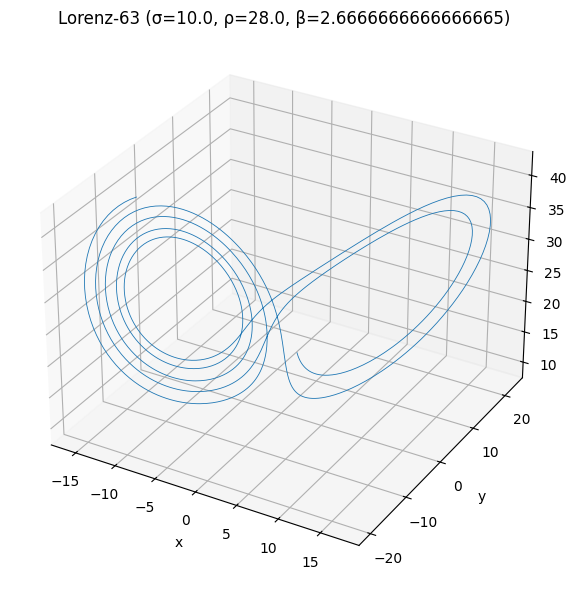

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers 3D projection
import os

def lorenz63(state, sigma=10.0, rho=28.0, beta=8/3):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.array([dx, dy, dz])

def rk4_step(f, state, dt, *args, **kwargs):
    k1 = f(state, *args, **kwargs)
    k2 = f(state + 0.5*dt*k1, *args, **kwargs)
    k3 = f(state + 0.5*dt*k2, *args, **kwargs)
    k4 = f(state + dt*k3, *args, **kwargs)
    return state + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def simulate_lorenz(initial_state, T=50.0, dt=0.01, sigma=10.0, rho=28.0, beta=8/3):
    n_steps = int(np.ceil(T / dt))
    ts = np.linspace(0, n_steps*dt, n_steps+1)
    traj = np.zeros((n_steps+1, 3))
    traj[0] = initial_state
    state = np.array(initial_state, dtype=float)
    for i in range(n_steps):
        state = rk4_step(lorenz63, state, dt, sigma, rho, beta)
        traj[i+1] = state
    return ts, traj

# Parameters (change these if you want different behaviour)
sigma = 10.0
rho = 28.0
beta = 8.0/3.0
initial = [1.3, 1.5, 17.0]
# initial = [1, 1, 1]
T = 5.0
dt = 0.005

# Run simulation
t, traj = simulate_lorenz(initial, T=T, dt=dt, sigma=sigma, rho=rho, beta=beta)
x, y, z = traj.T

l63 = traj.T


# 3D trajectory plot
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, linewidth=0.6)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(f'Lorenz-63 (σ={sigma}, ρ={rho}, β={beta})')
plt.tight_layout()
plt.show()


In [12]:
bins63 = get_bins(l63, 15)

In [13]:
binseq63 = bin_sequence(l63, bins63, 15)

In [14]:
A63, verts63, counts63 = adjacency(binseq63)

In [15]:
binloc63 = bin_centers(bins63,15)

In [16]:
G63 = digraph(A63, verts63, counts63, loops = False)

In [17]:
pic63 = graph_graph(G63, binloc63, arrows = True)

In [18]:
pic63.show()

In [19]:
D63 = distance_matrix(G63)

In [20]:
MNeighbor = DowkerComplex(D63).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgms1 = MNeighbor.persistence() #this is the gudhi built in persistence function

c:\Users\sunia\anaconda3\envs\CNN_env\Lib\site-packages\gudhi\persistence_graphical_tools.py:117: UserWarning:

usetex mode requires ghostscript.



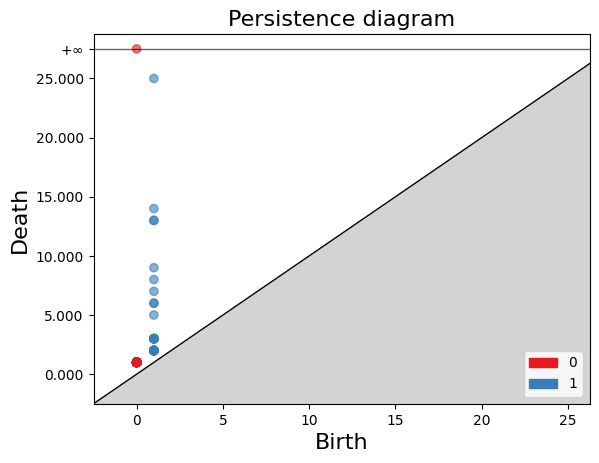

In [21]:
gd.plot_persistence_diagram(dgms1)
plt.show()

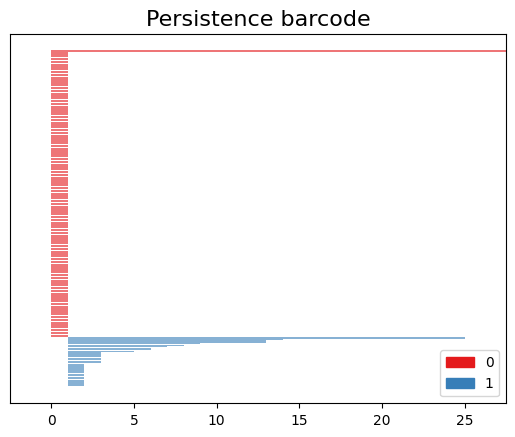

In [22]:
gd.plot_persistence_barcode(dgms1)
plt.show()

In [23]:
print("Bars: ",dgms1)

Bars:  [(1, (1.0, 25.0)), (1, (1.0, 14.0)), (1, (1.0, 13.0)), (1, (1.0, 13.0)), (1, (1.0, 9.0)), (1, (1.0, 8.0)), (1, (1.0, 7.0)), (1, (1.0, 6.0)), (1, (1.0, 6.0)), (1, (1.0, 5.0)), (1, (1.0, 3.0)), (1, (1.0, 3.0)), (1, (1.0, 3.0)), (1, (1.0, 3.0)), (1, (1.0, 3.0)), (1, (1.0, 3.0)), (1, (1.0, 3.0)), (1, (1.0, 3.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (0, (0.0, inf)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0

# Three Lorenz Trajectories

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers 3D projection
import os

initial1 = [1, 1, 1]
t1, traj1 = simulate_lorenz(initial1, T=T/3, dt=dt, sigma=sigma, rho=rho, beta=beta)
l63_1 = traj1.T

initial2 = [l63_1[0,-1]+1, l63_1[1,-1]+1, l63_1[2,-1]+1]
t2, traj2 = simulate_lorenz(initial2, T=T/3, dt=dt, sigma=sigma, rho=rho, beta=beta)
l63_2 = traj2.T

initial3 = [l63_2[0,-1]+2, l63_2[1,-1]+2, l63_2[2,-1]+2]
t3, traj3 = simulate_lorenz(initial3, T=T/3, dt=dt, sigma=sigma, rho=rho, beta=beta)
l63_3 = traj3.T


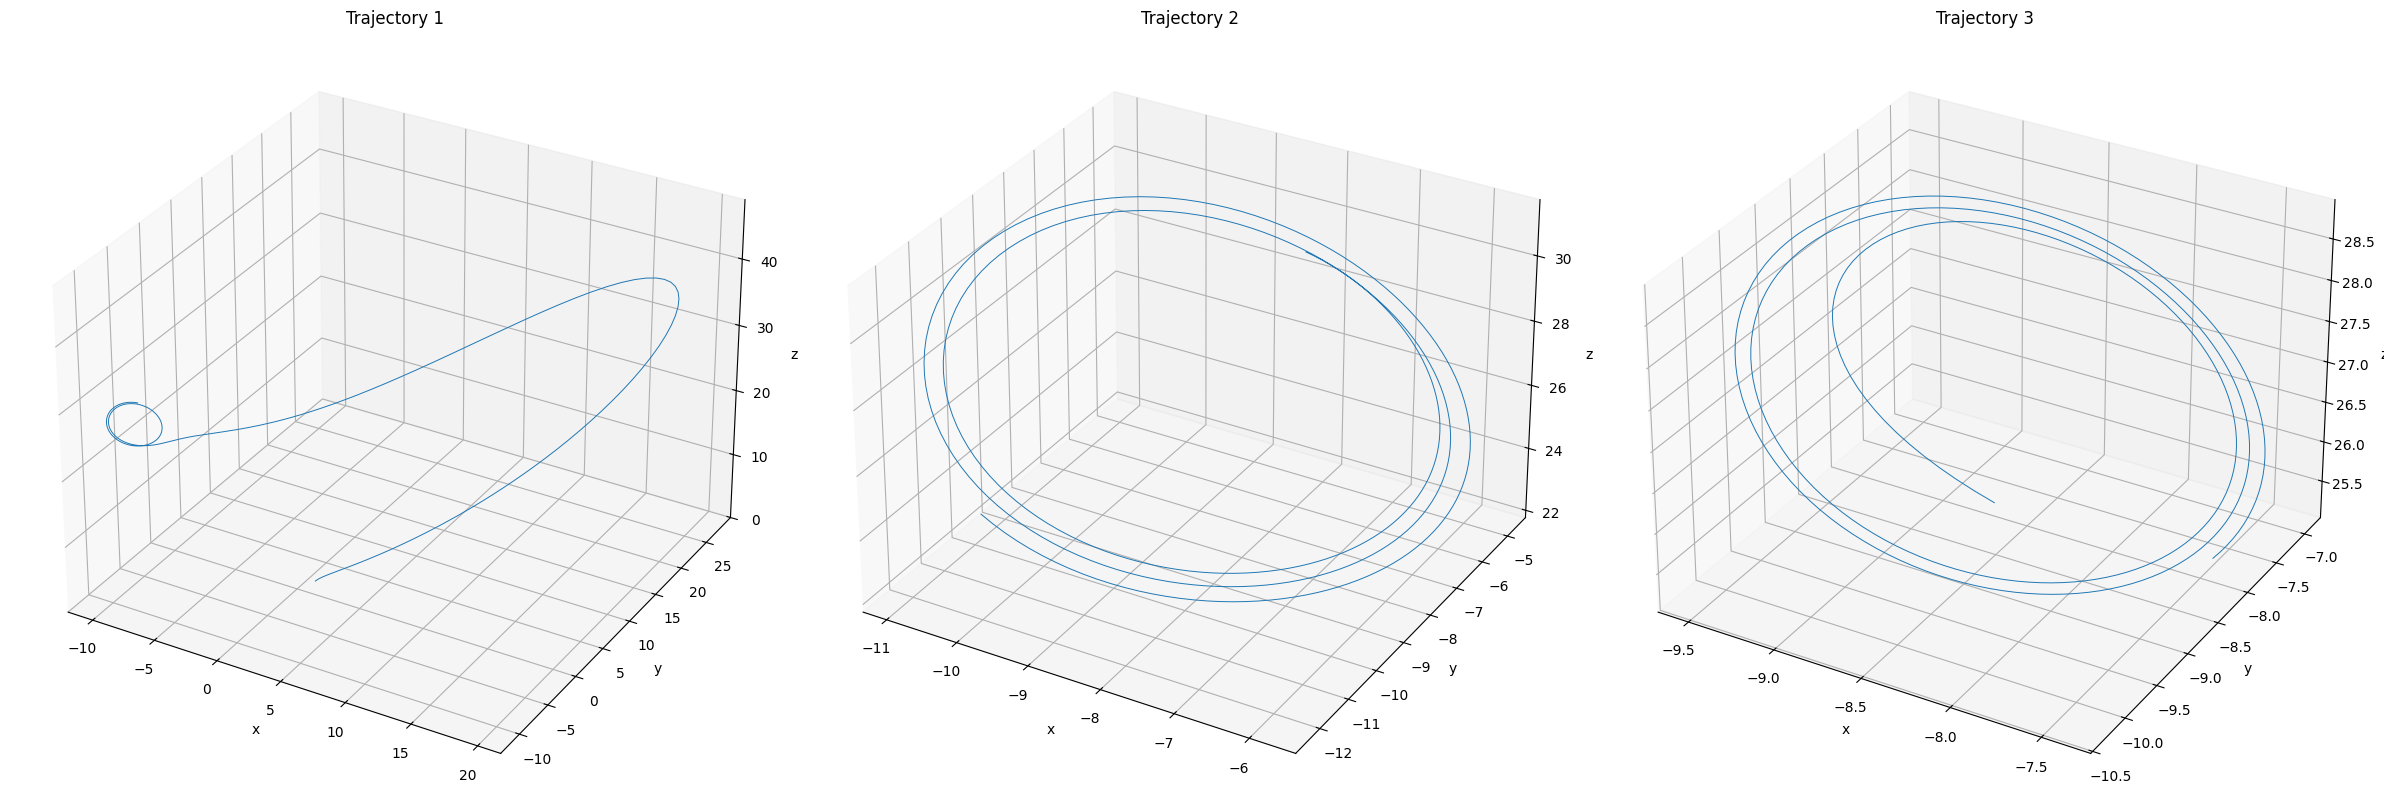

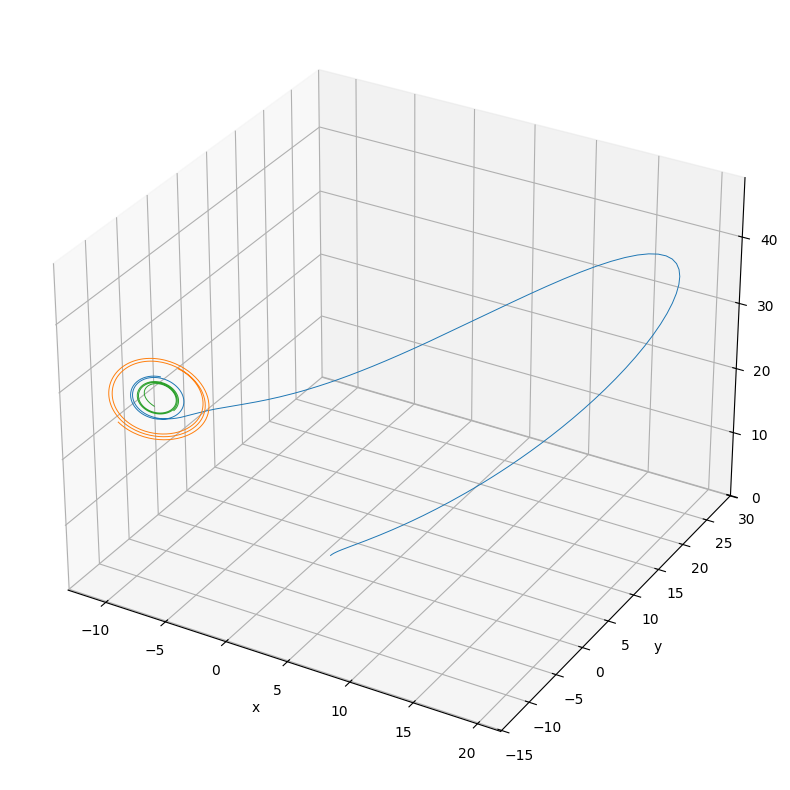

In [25]:
x1, y1, z1 = l63_1
x2, y2, z2 = l63_2
x3, y3, z3 = l63_3

fig = plt.figure(figsize=(24, 8))

# Subplot 1
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.plot(x1, y1, z1, lw=0.7)
ax1.set_title('Trajectory 1')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

# Subplot 2
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot(x2, y2, z2, lw=0.7)
ax2.set_title('Trajectory 2')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

# Subplot 3
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.plot(x3, y3, z3, lw=0.7)
ax3.set_title('Trajectory 3')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')

plt.tight_layout()
plt.show()


# Plot the trajectory with gaps
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x1, y1, z1, linewidth=0.7)
ax.plot(x2, y2, z2, linewidth=0.7)
ax.plot(x3, y3, z3, linewidth=0.7)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()


In [26]:
# Combine the trajectories to find the overall range for bins
combined_traj = np.concatenate((l63_1, l63_2, l63_3), axis=1)
global_bins = get_bins(combined_traj, 15)

# Get the combined bin sequence and calculate the vertices and counts
combined_binseq = bin_sequence(combined_traj, global_bins, 15)
combined_verts, combined_counts = np.unique(combined_binseq, return_counts=True)

# Create empty adjacency matrices of the same size
num_verts = len(combined_verts)
vert_map = {vert: i for i, vert in enumerate(combined_verts)}

A1 = np.zeros((num_verts, num_verts))
A2 = np.zeros((num_verts, num_verts))
A3 = np.zeros((num_verts, num_verts))

# Populate each adjacency matrix separately
binseq_A = bin_sequence(l63_1, global_bins, 15)
for i in range(len(binseq_A) - 1):
    start = vert_map[binseq_A[i]]
    end = vert_map[binseq_A[i+1]]
    A1[start, end] += 1

binseq_B = bin_sequence(l63_2, global_bins, 15)
for i in range(len(binseq_B) - 1):
    start = vert_map[binseq_B[i]]
    end = vert_map[binseq_B[i+1]]
    A2[start, end] += 1
    
binseq_C = bin_sequence(l63_3, global_bins, 15)
for i in range(len(binseq_C) - 1):
    start = vert_map[binseq_C[i]]
    end = vert_map[binseq_C[i+1]]
    A3[start, end] += 1

# Sum the individual adjacency matrices
combined_adjacency_matrix = A1 + A2 + A3

# Calculate bin centers for plotting
binloc = bin_centers(global_bins, 15)

# Now you can use these variables to plot the combined graph
combined_G = digraph(combined_adjacency_matrix, combined_verts, combined_counts, loops=False)
combined_pic = graph_graph(combined_G, binloc, arrows=True)

In [27]:
combined_pic.show()

In [28]:
D63 = distance_matrix(combined_G)

In [29]:
MNeighbor = DowkerComplex(D63).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgms2 = MNeighbor.persistence() #this is the gudhi built in persistence function

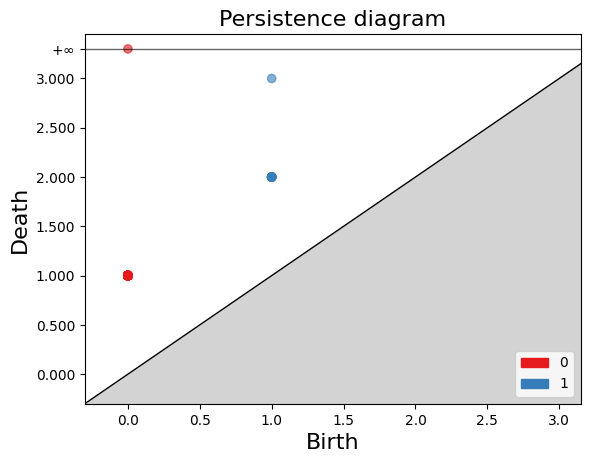

In [30]:
gd.plot_persistence_diagram(dgms2)
plt.show()

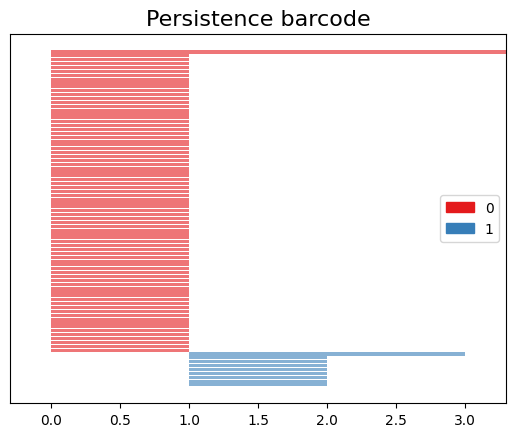

In [31]:
gd.plot_persistence_barcode(dgms2)
plt.show()

In [32]:
print("Bars: ",dgms2)

Bars:  [(1, (1.0, 3.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (0, (0.0, inf)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0

# Bottleneck Distance (between full lorenz and combined lorenz)

In [33]:
def separate_0s_1s(data):
    list_of_1s_xy = []
    list_of_0s_xy = []

    for item in data:
        if item[0] == 1:
            list_of_1s_xy.append(item[1])
        else:
            list_of_0s_xy.append(item[1])

    return list_of_1s_xy, list_of_0s_xy

In [34]:
from gudhi import bottleneck_distance

h0 = bottleneck_distance(separate_0s_1s(dgms1)[0], separate_0s_1s(dgms2)[0])
h1 = bottleneck_distance(separate_0s_1s(dgms1)[1], separate_0s_1s(dgms2)[1])

In [35]:
print("Bottleneck distance in H0: ", h0)
print("Bottleneck distance in H1: ", h1)

Bottleneck distance in H0:  12.0
Bottleneck distance in H1:  0.5


# Running Convergence Study

In [36]:
def get_dgms1(T, dt, initial):

    t, traj = simulate_lorenz(initial, T=T, dt=dt, sigma=sigma, rho=rho, beta=beta)
    l63 = traj.T

    bins63 = get_bins(l63, 15)
    binseq63 = bin_sequence(l63, bins63, 15)
    A63, verts63, counts63 = adjacency(binseq63)
    binloc63 = bin_centers(bins63,15)
    G63 = digraph(A63, verts63, counts63, loops = False)
    D63 = distance_matrix(G63)
    MNeighbor = DowkerComplex(D63).create_simplex_tree(filtration='Sublevel', max_dimension=2)
    dgms1 = MNeighbor.persistence()

    return dgms1

In [37]:
def analyze_segmented_trajectory(n, T, dt, sigma, rho, beta, initial):
    """
    Runs the full simulation and TDA pipeline for a trajectory broken into 'n' segments.
    Returns the h0 and h1 bottleneck distances compared to the ground truth.
    """

    dgms1 = get_dgms1(T, dt, initial)

    trajectories = []
    current_initial = initial
    segment_T = T / n

    for i in range(n):
        _, traj_segment = simulate_lorenz(current_initial, T=segment_T, dt=dt, sigma=sigma, rho=rho, beta=beta)
        trajectories.append(traj_segment.T)
        
        # Update initial condition with perturbation
        if traj_segment.shape[0] > 0:
            perturbation = (i + 1) * 0.1 
            current_initial = traj_segment[-1, :] + perturbation
        
    # Combine and run TDA
    combined_traj = np.concatenate(trajectories, axis=1)
    global_bins = get_bins(combined_traj, 15)

    combined_binseq = bin_sequence(combined_traj, global_bins, 15)
    combined_verts, combined_counts = np.unique(combined_binseq, return_counts=True)

    # Create empty adjacency matrices of the same size
    num_verts = len(combined_verts)
    vert_map = {vert: i for i, vert in enumerate(combined_verts)}

    A = [np.zeros((num_verts, num_verts)) for _ in range(n)]

    # Populate each adjacency matrix separately
    for idx, l63_i in enumerate(trajectories):
        binseq_A = bin_sequence(l63_i, global_bins, 15)
        for i in range(len(binseq_A) - 1):
            start = vert_map[binseq_A[i]]
            end = vert_map[binseq_A[i+1]]
            A[idx][start, end] += 1

    combined_adjacency_matrix = sum(A)

    # Calculate bin centers for plotting
    binloc = bin_centers(global_bins, 15)

    # Now you can use these variables to plot the combined graph
    combined_G = digraph(combined_adjacency_matrix, combined_verts, combined_counts, loops=False)
    combined_pic = graph_graph(combined_G, binloc, arrows=True)
    
    D63 = distance_matrix(combined_G)
    MNeighbor = DowkerComplex(D63).create_simplex_tree(filtration='Sublevel', max_dimension=2)
    dgms2 = MNeighbor.persistence() #this is the gudhi built in persistence function

    h0 = bottleneck_distance(separate_0s_1s(dgms1)[0], separate_0s_1s(dgms2)[0])
    h1 = bottleneck_distance(separate_0s_1s(dgms1)[1], separate_0s_1s(dgms2)[1])

    return h0, h1

In [ ]:
# dt = 0.01
# sigma = 10
# rho = 28
# beta = 8/3
# initial = np.array([1.0, 1.0, 1.0])

# T_values = np.arange(5, 105, 5)
# n_values = range(2, 25)

# h0_distances = np.zeros((len(T_values), len(n_values)))
# h1_distances = np.zeros((len(T_values), len(n_values)))

# for i, T in enumerate(T_values):
#     for j, n in enumerate(n_values):
#         print(f"Analyzing for T = {T}s, n = {n} segments...")
#         h0_dist, h1_dist = analyze_segmented_trajectory(n, T, dt, sigma, rho, beta, initial)
#         h0_distances[i, j] = h0_dist
#         h1_distances[i, j] = h1_dist

Analyzing for T = 5s, n = 2 segments...
Analyzing for T = 5s, n = 3 segments...
Analyzing for T = 5s, n = 4 segments...
Analyzing for T = 5s, n = 5 segments...
Analyzing for T = 5s, n = 6 segments...
Analyzing for T = 5s, n = 7 segments...
Analyzing for T = 5s, n = 8 segments...
Analyzing for T = 5s, n = 9 segments...
Analyzing for T = 5s, n = 10 segments...
Analyzing for T = 5s, n = 11 segments...
Analyzing for T = 5s, n = 12 segments...
Analyzing for T = 5s, n = 13 segments...
Analyzing for T = 5s, n = 14 segments...
Analyzing for T = 5s, n = 15 segments...
Analyzing for T = 5s, n = 16 segments...
Analyzing for T = 5s, n = 17 segments...
Analyzing for T = 5s, n = 18 segments...
Analyzing for T = 5s, n = 19 segments...
Analyzing for T = 5s, n = 20 segments...
Analyzing for T = 5s, n = 21 segments...
Analyzing for T = 5s, n = 22 segments...
Analyzing for T = 5s, n = 23 segments...
Analyzing for T = 5s, n = 24 segments...
Analyzing for T = 10s, n = 2 segments...
Analyzing for T = 10s, n

In [ ]:
# startT, endT = 0, 23
# T_val = T_values[startT:endT]
# startN, endN = 0, 21
# N_val = np.array(list(n_values))[startN:endN]

# h0_subset = h0_distances[startT:endT, startN:endN]
# h1_subset = h1_distances[startT:endT, startN:endN]

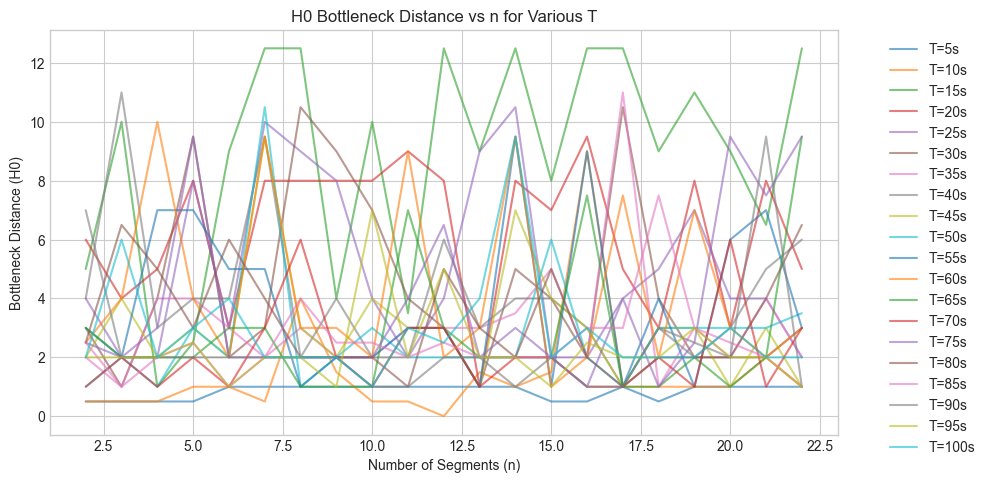

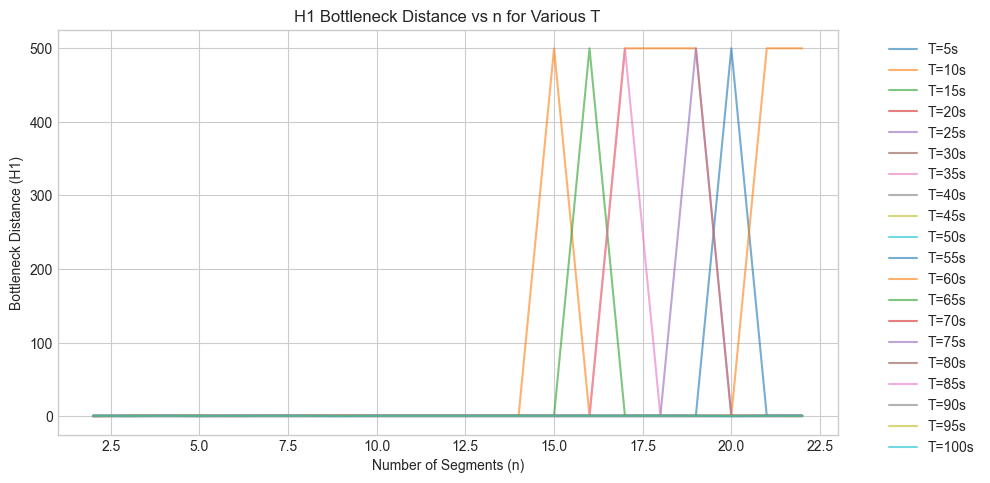

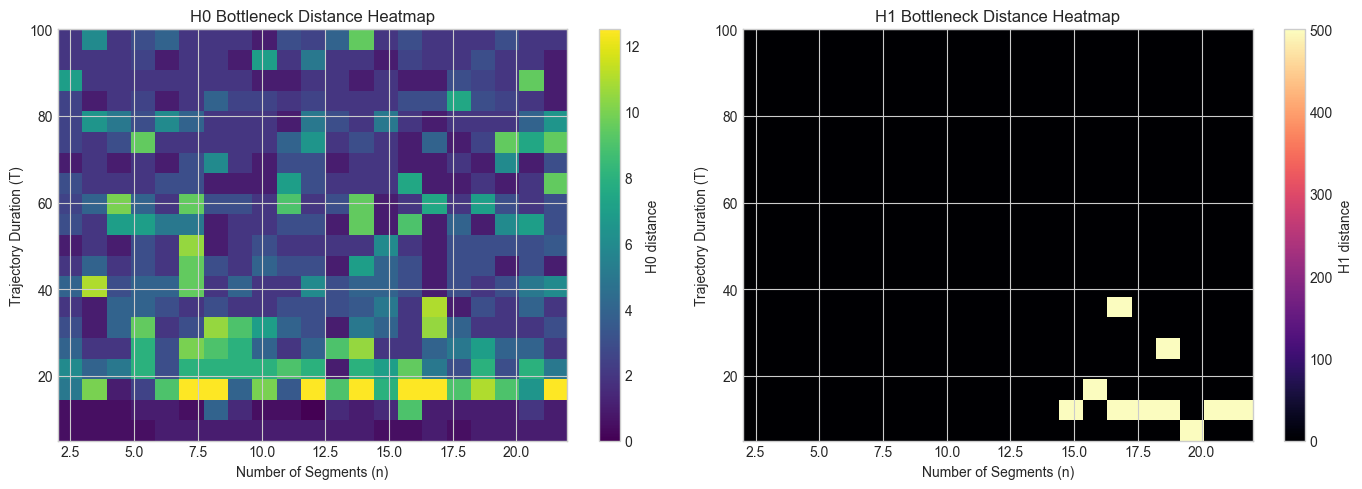

In [ ]:
# plt.figure(figsize=(10, 5))
# for i, T in enumerate(T_values):
#     plt.plot(N_val, h0_subset[i], label=f"T={T}s", alpha=0.6)
# plt.xlabel("Number of Segments (n)")
# plt.ylabel("Bottleneck Distance (H0)")
# plt.title("H0 Bottleneck Distance vs n for Various T")
# plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(10, 5))
# for i, T in enumerate(T_values):
#     plt.plot(N_val, h1_subset[i], label=f"T={T}s", alpha=0.6)
# plt.xlabel("Number of Segments (n)")
# plt.ylabel("Bottleneck Distance (H1)")
# plt.title("H1 Bottleneck Distance vs n for Various T")
# plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
# plt.tight_layout()
# plt.show()

# fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# im0 = ax[0].imshow(h0_subset, aspect='auto', origin='lower',
#                    extent=[min(N_val), max(N_val), min(T_val), max(T_val)],
#                    cmap='viridis')
# ax[0].set_title("H0 Bottleneck Distance Heatmap")
# ax[0].set_xlabel("Number of Segments (n)")
# ax[0].set_ylabel("Trajectory Duration (T)")
# fig.colorbar(im0, ax=ax[0], label="H0 distance")

# im1 = ax[1].imshow(h1_subset, aspect='auto', origin='lower',
#                    extent=[min(N_val), max(N_val), min(T_val), max(T_val)],
#                    cmap='magma')
# ax[1].set_title("H1 Bottleneck Distance Heatmap")
# ax[1].set_xlabel("Number of Segments (n)")
# ax[1].set_ylabel("Trajectory Duration (T)")
# fig.colorbar(im1, ax=ax[1], label="H1 distance")

# plt.tight_layout()
# plt.show()


In [ ]:
# np.save('h0_distances.npy', h0_distances)
# np.save('h1_distances.npy', h1_distances)


# Fixing the gaps between trajectory segments

In [38]:
def get_dgms1(T, dt, initial):

    t, traj = simulate_lorenz(initial, T=T, dt=dt, sigma=sigma, rho=rho, beta=beta)
    l63 = traj.T

    bins63 = get_bins(l63, 15)
    binseq63 = bin_sequence(l63, bins63, 15)
    A63, verts63, counts63 = adjacency(binseq63)
    binloc63 = bin_centers(bins63,15)
    G63 = digraph(A63, verts63, counts63, loops = False)
    D63 = distance_matrix(G63)
    MNeighbor = DowkerComplex(D63).create_simplex_tree(filtration='Sublevel', max_dimension=2)
    dgms1 = MNeighbor.persistence()

    return dgms1

In [39]:
def analyze_segmented_trajectory(n, T, dt, sigma, rho, beta, initial):
    """
    Runs the full simulation and TDA pipeline for a trajectory broken into 'n' segments.
    Returns the h0 and h1 bottleneck distances compared to the ground truth.
    """

    dgms1 = get_dgms1(T, dt, initial)

    # trajectories = []
    # current_initial = initial
    # segment_T = T / n

    # for i in range(n):
    #     _, traj_segment = simulate_lorenz(current_initial, T=segment_T, dt=dt, sigma=sigma, rho=rho, beta=beta)
    #     trajectories.append(traj_segment.T)
        
    #     # Update initial condition with perturbation
    #     if traj_segment.shape[0] > 0:
    #         perturbation = (i + 1) * 0.1 
    #         current_initial = traj_segment[-1, :] + perturbation

    trajectories = []
    current_initial = initial
    segment_T = T / n

    for i in range(n):
        _, traj_segment = simulate_lorenz(
            current_initial, T=segment_T, dt=dt,
            sigma=sigma, rho=rho, beta=beta
        )
        trajectories.append(traj_segment.T)

        # Move 5% ahead along the trajectory for the next initial condition
        if traj_segment.shape[0] > 0:
            _, traj_ahead = simulate_lorenz(
                traj_segment[-1, :],
                T=0.05 * segment_T, dt=dt,
                sigma=sigma, rho=rho, beta=beta
            )
            current_initial = traj_ahead[-1, :]

    # Combine and run TDA
    combined_traj = np.concatenate(trajectories, axis=1)
    global_bins = get_bins(combined_traj, 15)

    combined_binseq = bin_sequence(combined_traj, global_bins, 15)
    combined_verts, combined_counts = np.unique(combined_binseq, return_counts=True)

    # Create empty adjacency matrices of the same size
    num_verts = len(combined_verts)
    vert_map = {vert: i for i, vert in enumerate(combined_verts)}

    A = [np.zeros((num_verts, num_verts)) for _ in range(n)]

    # Populate each adjacency matrix separately
    for idx, l63_i in enumerate(trajectories):
        binseq_A = bin_sequence(l63_i, global_bins, 15)
        for i in range(len(binseq_A) - 1):
            start = vert_map[binseq_A[i]]
            end = vert_map[binseq_A[i+1]]
            A[idx][start, end] += 1

    combined_adjacency_matrix = sum(A)

    # Calculate bin centers for plotting
    binloc = bin_centers(global_bins, 15)

    # Now you can use these variables to plot the combined graph
    combined_G = digraph(combined_adjacency_matrix, combined_verts, combined_counts, loops=False)
    combined_pic = graph_graph(combined_G, binloc, arrows=True)
    
    D63 = distance_matrix(combined_G)
    MNeighbor = DowkerComplex(D63).create_simplex_tree(filtration='Sublevel', max_dimension=2)
    dgms2 = MNeighbor.persistence() #this is the gudhi built in persistence function

    h0 = bottleneck_distance(separate_0s_1s(dgms1)[0], separate_0s_1s(dgms2)[0])
    h1 = bottleneck_distance(separate_0s_1s(dgms1)[1], separate_0s_1s(dgms2)[1])

    return h0, h1

In [40]:
dt = 0.01
sigma = 10
rho = 28
beta = 8/3
initial = np.array([1.0, 1.0, 1.0])

T_values = np.arange(5, 105, 5)
n_values = range(2, 25)

h0_distances = np.zeros((len(T_values), len(n_values)))
h1_distances = np.zeros((len(T_values), len(n_values)))

for i, T in enumerate(T_values):
    for j, n in enumerate(n_values):
        print(f"Analyzing for T = {T}s, n = {n} segments...")
        h0_dist, h1_dist = analyze_segmented_trajectory(n, T, dt, sigma, rho, beta, initial)
        h0_distances[i, j] = h0_dist
        h1_distances[i, j] = h1_dist

Analyzing for T = 5s, n = 2 segments...
Analyzing for T = 5s, n = 3 segments...
Analyzing for T = 5s, n = 4 segments...
Analyzing for T = 5s, n = 5 segments...
Analyzing for T = 5s, n = 6 segments...
Analyzing for T = 5s, n = 7 segments...
Analyzing for T = 5s, n = 8 segments...
Analyzing for T = 5s, n = 9 segments...
Analyzing for T = 5s, n = 10 segments...
Analyzing for T = 5s, n = 11 segments...
Analyzing for T = 5s, n = 12 segments...
Analyzing for T = 5s, n = 13 segments...
Analyzing for T = 5s, n = 14 segments...
Analyzing for T = 5s, n = 15 segments...
Analyzing for T = 5s, n = 16 segments...
Analyzing for T = 5s, n = 17 segments...
Analyzing for T = 5s, n = 18 segments...
Analyzing for T = 5s, n = 19 segments...
Analyzing for T = 5s, n = 20 segments...
Analyzing for T = 5s, n = 21 segments...
Analyzing for T = 5s, n = 22 segments...
Analyzing for T = 5s, n = 23 segments...
Analyzing for T = 5s, n = 24 segments...
Analyzing for T = 10s, n = 2 segments...
Analyzing for T = 10s, n

In [43]:
startT, endT = 0, 23
T_val = T_values[startT:endT]
startN, endN = 0, 21
N_val = np.array(list(n_values))[startN:endN]

h0_subset = h0_distances[startT:endT, startN:endN]
h1_subset = h1_distances[startT:endT, startN:endN]

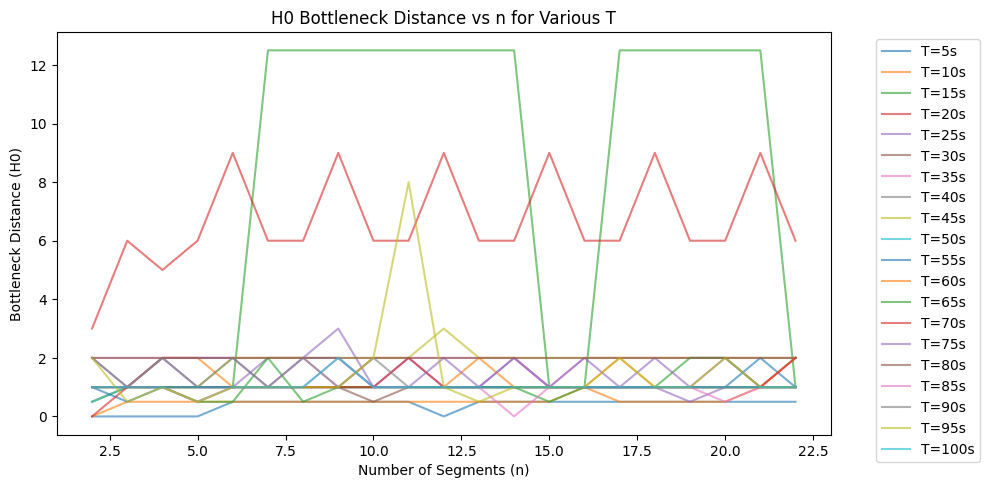

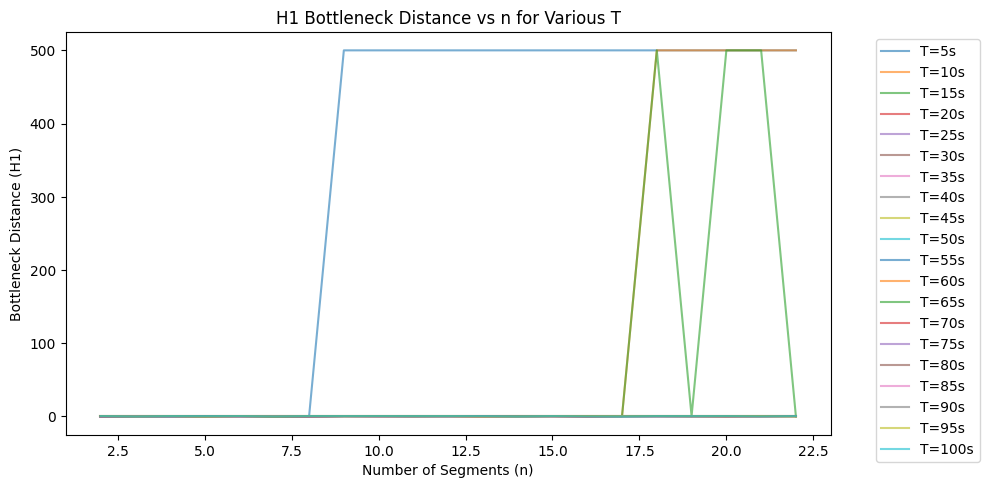

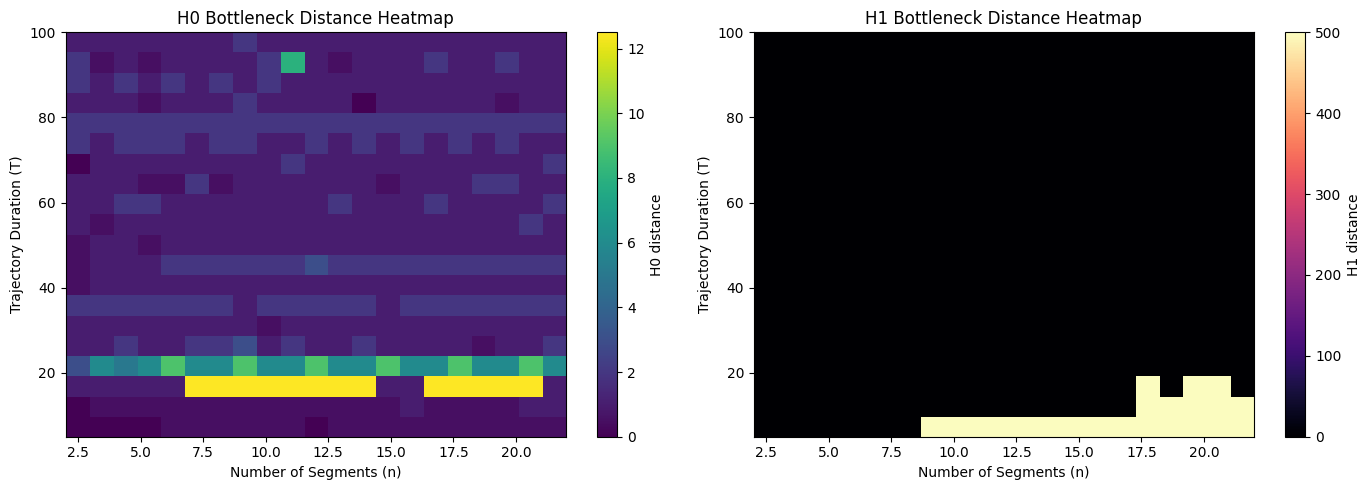

In [44]:
plt.figure(figsize=(10, 5))
for i, T in enumerate(T_values):
    plt.plot(N_val, h0_subset[i], label=f"T={T}s", alpha=0.6)
plt.xlabel("Number of Segments (n)")
plt.ylabel("Bottleneck Distance (H0)")
plt.title("H0 Bottleneck Distance vs n for Various T")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for i, T in enumerate(T_values):
    plt.plot(N_val, h1_subset[i], label=f"T={T}s", alpha=0.6)
plt.xlabel("Number of Segments (n)")
plt.ylabel("Bottleneck Distance (H1)")
plt.title("H1 Bottleneck Distance vs n for Various T")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

im0 = ax[0].imshow(h0_subset, aspect='auto', origin='lower',
                   extent=[min(N_val), max(N_val), min(T_val), max(T_val)],
                   cmap='viridis')
ax[0].set_title("H0 Bottleneck Distance Heatmap")
ax[0].set_xlabel("Number of Segments (n)")
ax[0].set_ylabel("Trajectory Duration (T)")
fig.colorbar(im0, ax=ax[0], label="H0 distance")

im1 = ax[1].imshow(h1_subset, aspect='auto', origin='lower',
                   extent=[min(N_val), max(N_val), min(T_val), max(T_val)],
                   cmap='magma')
ax[1].set_title("H1 Bottleneck Distance Heatmap")
ax[1].set_xlabel("Number of Segments (n)")
ax[1].set_ylabel("Trajectory Duration (T)")
fig.colorbar(im1, ax=ax[1], label="H1 distance")

plt.tight_layout()
plt.show()


In [45]:
np.save('h0_distances.npy', h0_distances)
np.save('h1_distances.npy', h1_distances)